# **DETECT ANOMALIES IN STOCK PRICES USING LONG SHORT-TERM MEMORY (LSTM)**
## Aim: 
*   Spot anomalies in the stock prices, if the deviation of the actual price from the predicted price of the model is higher than 1% of the historical mean absolute error (MAE) 

## Applications:

*   Stock Trading: Use anomaly detection for trading strategies and risk management
*   Banks and Regulators: Spot fraudulent activities and insider trading
*   Likewise, this can also be applied in other fields such as detecting fraudulent credit card transactions, identifying equipment failures and medical diagnosis


### **(1) Fetch Real Stock Price Data**

In [81]:
# Import libraries
import pandas as pd
import plotly.express as pxa
from copy import copy
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import plotly.figure_factory as ff
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import datetime
import yfinance as yf
from tensorflow import keras

In [82]:
# Download stock prices from 2015 to the current stock price
ticker = ['TSLA']
df_prices = pd.DataFrame()

start_date = "2015-01-01"
end_date = datetime.date.today() # today's date
stock_prices = yf.download(ticker, start_date, end_date, progress = False)

stock_prices.columns = stock_prices.columns.droplevel(1)  # Drop the "Ticker" level

stock_prices = stock_prices.reset_index()
df_prices["Date"] = stock_prices["Date"]
df_prices["Close"] = stock_prices["Close"]
df_prices

,Date,Close
0,2015-01-02,14.620667
1,2015-01-05,14.006000
2,2015-01-06,14.085333
3,2015-01-07,14.063333
4,2015-01-08,14.041333
...,...,...
2555,2025-03-03,284.649994
2556,2025-03-04,272.040009
2557,2025-03-05,279.100006
2558,2025-03-06,263.450012


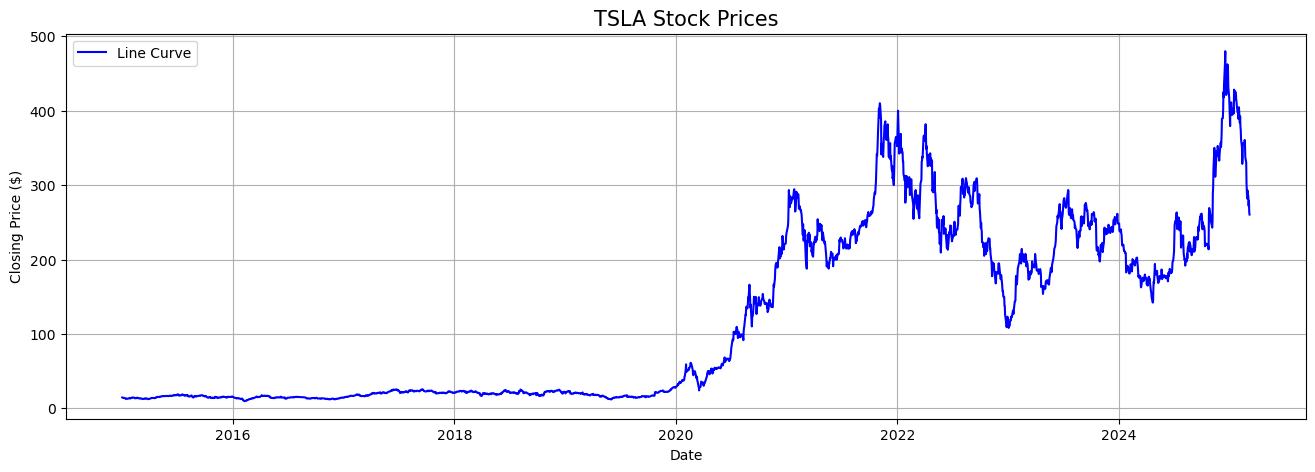

In [83]:
# Plot the line chart of the closing prices
plt.figure(figsize=(16, 5)) 
plt.plot(df_prices['Date'], df_prices["Close"], color='b', label='Line Curve')
plt.xlabel("Date")
plt.ylabel("Closing Price ($)")
plt.title(ticker[0] +" Stock Prices", size=15)

plt.grid(True)
plt.legend()
plt.show()

### **(2) Normalize Stock Prices**

In [84]:
prices = df_prices[['Close']].values # get the closing prices in 2-D array
prices

array([[ 14.62066746],
       [ 14.00599957],
       [ 14.08533287],
       ...,
       [279.1000061 ],
       [263.45001221],
       [260.37149048]])

In [85]:
# Normalize stock prices between 0 and 1
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices)

### **(3) Create Training and Testing Data**

In [86]:
X = [] # input features
y = [] # target labels

sequence_length = 50  # Use past 50 days to predict next day
for i in range(sequence_length, len(prices_scaled)):
    X.append(prices_scaled[i-sequence_length:i, 0])
    y.append(prices_scaled[i, 0])

In [87]:
# Convert the data into array format
X = np.asarray(X)
y = np.asarray(y)

In [88]:
# Split the data into training (70%) and testing data (30%)
split = int(0.7 * len(X))
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

In [89]:
# Reshape the 1D arrays to 3D arrays to feed in the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_train.shape, X_test.shape

((1757, 50, 1), (753, 50, 1))

### **(4) Build LSTM Autoencoder**

In [90]:
# Create the model
inputs = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])) # the input parameters are the dimensions of the array
# Set the return_sequence to true as to return the last output or not for sorting out the dimension problem
x = keras.layers.LSTM(150, return_sequences= True)(inputs) # set 150 neutrons for the LSTM layer.
x = keras.layers.Dropout(0.2)(x) # Set the dropout rate as 0.2
x = keras.layers.LSTM(150, return_sequences=True)(x) # the inputs of the 2nd layer is x from the previous layer and so on
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.LSTM(150)(x)
outputs = keras.layers.Dense(1, activation='linear')(x) # output layer

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss="mse")
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 50, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 50, 150)             │          91,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 50, 150)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 50, 150)             │         180,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50, 150)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 150)                 │         180,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 452,551 (1.73 MB)

 Trainable params: 452,551 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

In [91]:
# Fitting the model with the training data
# Add EarlyStopping to prevent overfitting
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 225ms/step - loss: 3.0232e-04 - val_loss: 0.0537
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 184ms/step - loss: 0.0053 - val_loss: 0.0159
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - loss: 0.0060 - val_loss: 0.0061
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - loss: 0.0111 - val_loss: 0.0053
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - loss: 0.0082 - val_loss: 0.0273
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - loss: 9.9900e-04 - val_loss: 0.0024
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 191ms/step - loss: 2.4258e-04 - val_loss: 0.0024
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - loss: 1.7920e-04 - val_loss: 0.0025
Epoch 9/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - loss: 1.6722e-04 - val_loss: 0.0026
Epoch 10/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - loss: 3.8632e-04 - val_loss: 0.0023
Epoch 11/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step - loss: 2.1134e-04 - val_loss: 0.0024
Epoch 12/30
50/50 ━━━━

### **(5) Predict Stock Prices and Detect Anomalies**

In [92]:
# Make prediction of the training data
predicted_train = model.predict(X_train, verbose=0)
predicted_train.shape

(1757, 1)

In [93]:
# Reshape the prediction to 2D array for comparison
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  
X_train_reshaped.shape

(1757, 50)

Reconstruction error threshold:  0.17999224124614815


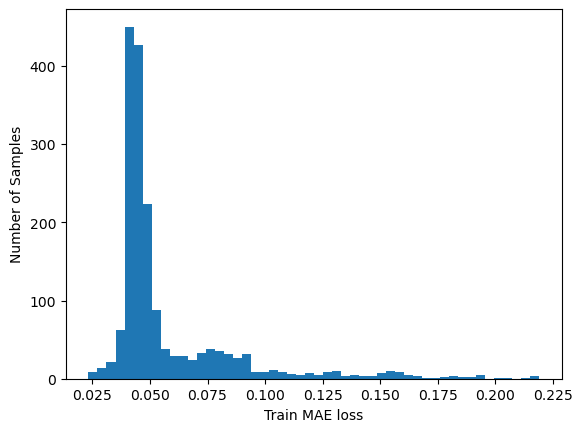

In [94]:
# Calculate the mean absolute error of the training data
train_mae_loss = np.mean(np.abs(predicted_train - X_train_reshaped), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

#threshold = np.max(train_mae_loss) # set the threshold of the anomaly to the max of MAE of the training dataset
threshold = np.percentile(train_mae_loss, 99)  # Top 1% as anomalies
print("Reconstruction error threshold: ",threshold)

In [95]:
# Make prediction of the testing data
predicted_test = model.predict(X_test, verbose=0)

In [96]:
# Reshape the prediction to 2D array for comparison
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)  
X_test_reshaped.shape

(753, 50)

In [97]:
# Calculate the mean absolute error of the testing data
test_mae_loss = np.mean(np.abs(predicted_test-X_test_reshaped), axis=1)

In [98]:
# Create a dataframe for storing the results of anomalies for the test data
test_anomaly = df_prices[split+sequence_length:][['Date']]
test_anomaly['Close'] = df_prices[split+sequence_length:]['Close']
test_anomaly['Loss'] = test_mae_loss
test_anomaly['Threshold'] = threshold
test_anomaly['Anomaly'] = test_anomaly['Loss'] > test_anomaly['Threshold']

test_anomaly

,Date,Close,Loss,Threshold,Anomaly
1807,2022-03-08,274.799988,0.065134,0.179992,False
1808,2022-03-09,286.323334,0.063912,0.179992,False
1809,2022-03-10,279.433319,0.061622,0.179992,False
1810,2022-03-11,265.116669,0.059645,0.179992,False
1811,2022-03-14,255.456665,0.058494,0.179992,False
...,...,...,...,...,...
2555,2025-03-03,284.649994,0.133252,0.179992,False
2556,2025-03-04,272.040009,0.140246,0.179992,False
2557,2025-03-05,279.100006,0.146807,0.179992,False
2558,2025-03-06,263.450012,0.152893,0.179992,False


In [99]:
# Check the prices and dates with anomalies
anomalies = test_anomaly.loc[test_anomaly['Anomaly'] == True]
anomalies

,Date,Close,Loss,Threshold,Anomaly
2131,2023-06-22,264.609985,0.182081,0.179992,True
2132,2023-06-23,256.600006,0.185350,0.179992,True
2133,2023-06-26,241.050003,0.186548,0.179992,True
2134,2023-06-27,250.210007,0.185322,0.179992,True
2135,2023-06-28,256.239990,0.181443,0.179992,True
2504,2024-12-13,436.230011,0.186923,0.179992,True
2505,2024-12-16,463.019989,0.194936,0.179992,True
2506,2024-12-17,479.859985,0.205458,0.179992,True
2507,2024-12-18,440.130005,0.217281,0.179992,True
2508,2024-12-19,436.170013,0.224993,0.179992,True


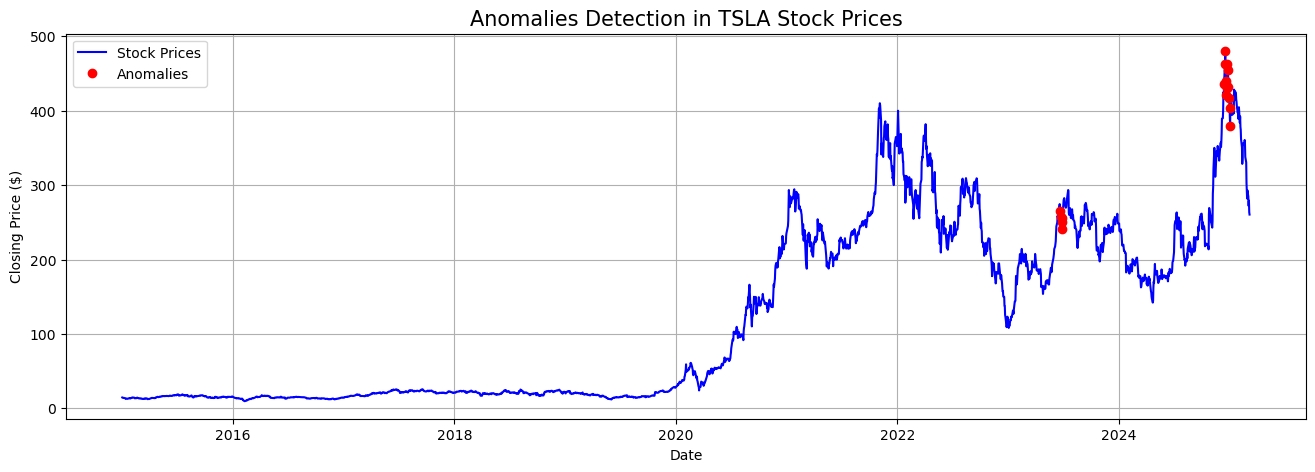

In [100]:
# Plot the line chart of the closing prices with discrete dots
plt.figure(figsize=(16, 5)) 

# Plot the main data points as discrete dots
plt.plot(df_prices['Date'], df_prices["Close"], marker='', color='b', linestyle='-', label='Stock Prices')

# Plot the anomalies as red dots
plt.plot(anomalies['Date'], anomalies["Close"], marker='o', color='r', linestyle='', label='Anomalies')

# Labels and title
plt.xlabel("Date")
plt.ylabel("Closing Price ($)")
plt.title("Anomalies Detection in " + ticker[0] + " Stock Prices", size=15)

plt.grid(True)
plt.legend()
plt.show()

### **(6) Model Evaluation**

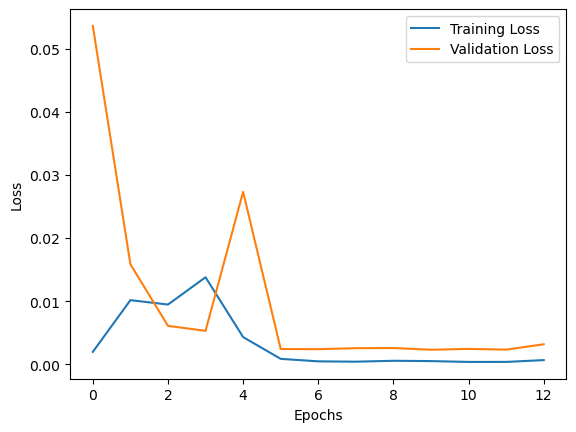

In [101]:
# Plot the graphs of training loss and validation loss
# Both curves show a steady decline in loss and coverage to the min, a sign of good generalization of the LSTM model
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [102]:
df = df_prices.copy()
df['SMA_50'] = df_prices['Close'].rolling(window=50).mean()  # 50-day SMA
df['SMA_200'] = df_prices['Close'].rolling(window=200).mean()  # 200-day SMA

print(df.tail())

           Date       Close      SMA_50     SMA_200
2555 2025-03-03  284.649994  385.712399  279.327950
2556 2025-03-04  272.040009  381.555999  279.800400
2557 2025-03-05  279.100006  378.335399  280.325950
2558 2025-03-06  263.450012  374.880999  280.769000
2559 2025-03-07  260.371490  371.667229  281.183557


In [103]:
# Calculate the MAE and RMSE of the predicted values of the test dataset
# Considering the range of actual stock price, the error implied from the prediction of the model is around 8.6%
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(predicted_test.reshape(-1), y_test.reshape(-1))
print("Mean Absolute Error (MAE):", mae)

rmse = np.sqrt(mean_squared_error(predicted_test.reshape(-1), y_test.reshape(-1)))
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 0.05840005494057037
Root Mean Squared Error (RMSE): 0.06700018983322845


### **(7) Insights**


Here are the anomalies found by the model, which are in-line with the actual price movement during the same period.


**Jun-2023**: TSLA shares surged by nearly 30% month-on-month in June 2023, on the back of AI and EV (Electric Vehicle) market growth and its strong deliveries.

**Dec-2024**: After TSLA shares reached its all-time high on 17th Decemeber 2024 on optimism of Donald Trump's election victory, the shares dropped significantly, due to weak market sentiment on trade tariffs by the US as well as TESLA's declining sales data.

By identifying anomalies in stock prices, traders can profit from the temporary price discrepancies due to arbitrage. Pair trade is one common strategy, where traders take a long position of an undervalued stock and a short position of an overvalued stock which has high historical correlation of the former.